In [1]:
# this clones the PGM repository in the ../PGM folder if it does not exists
# please modify this line as needed if you want to have the PMG repository elsewhere
import os, sys
pgm_path = '../PGM/'
if not os.path.isdir(pgm_path): # check if folder exists
    from git import Repo
    Repo.clone_from("https://github.com/jertubiana/PGM.git", pgm_path)
sys.path.append(pgm_path + 'source/')
sys.path.append(pgm_path + 'utilities/')
sys.path.append('../DNA_utils/')

In [2]:
# imports
from common_imports import set_num_threads
set_num_threads(2) # Set the number of cores. Must be executed before importing numpy&numba.
import rbm, RBM_utils
import DNA_utils, DNA_sequence_logo, DNA_plots_utils

import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

../PGM/source\numba_utilities.py:1124: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, F), array(float32, 2d, A))
  dmean_v_dw = np.dot(s1.T, V)
../PGM/source\numba_utilities.py:961: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 1d, A), array(float32, 2d, A))
  mean_V = np.dot(weights, V) / sum_weights


In [3]:
# load data
path = '../data/'
filename = 's100_6th.fasta'
all_data_6, counts_6 = DNA_utils.load_DNA_MSA(path + filename, drop_duplicates=True, with_counts = True)

filename = 's100_8th.fasta'
all_data_8, counts_8 = DNA_utils.load_DNA_MSA(path + filename, drop_duplicates=True, with_counts = True)

# split left and right data at round 8
full_data_8 = np.repeat(all_data_8, counts_8, axis=0)
seqs_8_l_2num, counts_8_l = np.unique(all_data_8[:, :20], return_counts=True, axis=0)
all_data_8_l = pd.DataFrame({'sequence' : DNA_utils.num2seq(seqs_8_l_2num),
                             'counts' : counts_8_l})
seqs_8_r_2num, counts_8_r = np.unique(all_data_8[:, 20:], return_counts=True, axis=0)
all_data_8_r = pd.DataFrame({'sequence' : DNA_utils.num2seq(seqs_8_r_2num),
                             'counts' : counts_8_r})
# put both rounds together
all_data_8_lr = pd.concat([all_data_8_l, all_data_8_r])
all_data_8_lr = all_data_8_lr.reset_index(drop=True)
all_data_8_lr = all_data_8_lr.groupby(by=["sequence"], as_index=False).sum()
all_data_8_lr = all_data_8_lr.sort_values(by='counts', ascending=False).reset_index(drop=True)
all_seq_8_lr = DNA_utils.seq2num(all_data_8_lr["sequence"].to_list())
counts_8_lr = all_data_8_lr['counts'].to_numpy()

# RBM-DC6 re-training

In [9]:
# fix training and validation set
perm = np.arange(all_data_6.shape[0])
np.random.shuffle(perm)

len_validation = all_data_6.shape[0] // 10
training_set_s2n = all_data_6[perm][:-len_validation]
training_set_counts = counts_6[perm][:-len_validation]
validation_set_s2n = all_data_6[perm][-len_validation:]
validation_set_counts = counts_6[perm][-len_validation:]

In [10]:
#resample training set with counts
dataset_size = training_set_s2n.shape[0] # same size of the training dataset used for RBM-SU
probs = training_set_counts
seqs = training_set_s2n
tot_probs = np.sum(probs)
probs2 = np.array(probs/tot_probs, dtype = np.float64)
tower = np.zeros(len(probs2), dtype = np.float64)
t = 0
for i, pr in enumerate(probs2):
    t = t + pr
    tower[i] = t
resampled_seq2num = []
for i in range(dataset_size):
    x = np.random.random()
    idx = tower.searchsorted(x)
    resampled_seq2num.append(seqs[idx])
resampled_seq2num = np.array(resampled_seq2num)
train_data_C = np.copy(resampled_seq2num)

In [11]:
# training
n_v = train_data_C.shape[1] # Number of visible units; = # sites in alignment.
n_h = 90
nmc = 10 # Number of Monte Carlo steps between each update.
lib = 1e-2 # L1b regularization. Default : 0.
visible = 'Potts' # Nature of visible units potential. Here, Potts states.
n_cv = 4
hidden = 'dReLU' # Nature of hidden units potential. Here, dReLU potential.
train_len = train_data_C.shape[0]
RBM_DC6 = rbm.RBM(visible = visible, hidden = hidden, n_v = n_v, n_h = n_h, n_cv = n_cv)
batch_size = 500 # Size of mini-batches (and number of Markov chains used).
n_updates = int(2e4)
n_iter = (n_updates // (train_data_C.shape[0] // batch_size))
print('Using ', n_iter, ' epochs.')

RBM_DC6.fit(train_data_C, batch_size = batch_size, n_iter = n_iter, l1b = lib, N_MC = nmc, verbose = 0, vverbose = 1)

Using  15  epochs.
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting epoch 11
Starting epoch 12
Starting epoch 13
Starting epoch 14
Starting epoch 15


{}

In [15]:
# resample test set with counts
dataset_size = validation_set_s2n.shape[0] # same size of the validation dataset used for RBM-SU
probs = validation_set_counts
seqs = validation_set_s2n
tot_probs = np.sum(probs)
probs2 = np.array(probs/tot_probs, dtype = np.float64)
tower = np.zeros(len(probs2), dtype = np.float64)
t = 0
for i, pr in enumerate(probs2):
    t = t + pr
    tower[i] = t
resampled_seq2num = []
for i in range(dataset_size):
    x = np.random.random()
    idx = tower.searchsorted(x)
    resampled_seq2num.append(seqs[idx])
resampled_seq2num = np.array(resampled_seq2num)
test_data_C = np.copy(resampled_seq2num)

''

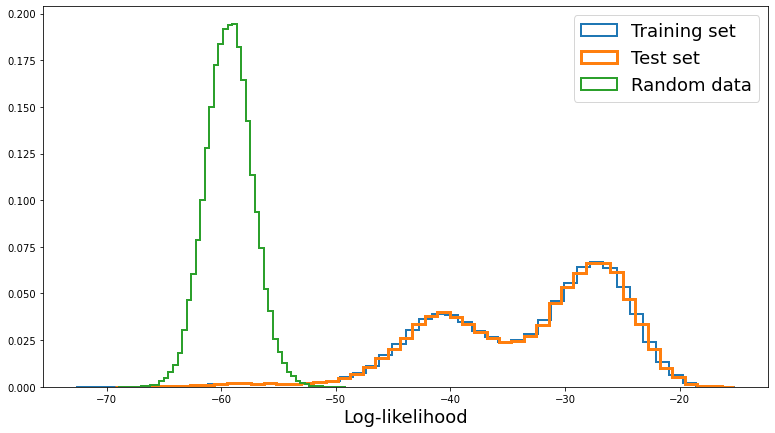

In [16]:
# check results on test set and on a set of random sequences
rand_data = np.random.randint(low=0, high=3, size=test_data.shape, dtype=np.int16)

fig = plt.figure(figsize=(13, 7), constrained_layout=False)
ax = fig.add_subplot()
ax.hist(RBM_DC6.likelihood(train_data_C), bins=50, density=True, histtype='step', lw=2, fill=False, label="Training set")
ax.hist(RBM_DC6.likelihood(test_data_C), bins=50, density=True, histtype='step', lw=3, fill=False, label="Test set")
ax.hist(RBM_DC6.likelihood(rand_data), bins=50, density=True, histtype='step', lw=2, fill=False, label="Random data")

ax.legend(fontsize=18, loc=1)
ax.set_xlabel("Log-likelihood", fontsize=18)
;

In [17]:
# save RBM
out_path = './RBM_retrained/'
if not os.path.isdir(out_path): # check if folder exists
    os.makedirs(out_path)
    
file_name = 'RBM_DC6.data'
RBM_utils.saveRBM(out_path + file_name, RBM_DC6)

# RBM-DC8 re-training

In [41]:
# fix training and validation set
perm = np.arange(all_data_8.shape[0])
np.random.shuffle(perm)

len_validation = all_data_8.shape[0] // 10
training_set_s2n = all_data_8[perm][:-len_validation]
training_set_counts = counts_8[perm][:-len_validation]
validation_set_s2n = all_data_8[perm][-len_validation:]
validation_set_counts = counts_8[perm][-len_validation:]

In [42]:
#resample training set with counts
dataset_size = training_set_s2n.shape[0] # same size of the training dataset used for RBM-SU
probs = training_set_counts
seqs = training_set_s2n
tot_probs = np.sum(probs)
probs2 = np.array(probs/tot_probs, dtype = np.float64)
tower = np.zeros(len(probs2), dtype = np.float64)
t = 0
for i, pr in enumerate(probs2):
    t = t + pr
    tower[i] = t
resampled_seq2num = []
for i in range(dataset_size):
    x = np.random.random()
    idx = tower.searchsorted(x)
    resampled_seq2num.append(seqs[idx])
resampled_seq2num = np.array(resampled_seq2num)
train_data_C = np.copy(resampled_seq2num)

In [43]:
# training
n_v = train_data_C.shape[1] # Number of visible units; = # sites in alignment.
n_h = 90
nmc = 10 # Number of Monte Carlo steps between each update.
lib = 1e-2 # L1b regularization. Default : 0.
visible = 'Potts' # Nature of visible units potential. Here, Potts states.
n_cv = 4
hidden = 'dReLU' # Nature of hidden units potential. Here, dReLU potential.
train_len = train_data_C.shape[0]
RBM_DC8 = rbm.RBM(visible = visible, hidden = hidden, n_v = n_v, n_h = n_h, n_cv = n_cv)
batch_size = 500 # Size of mini-batches (and number of Markov chains used).
n_updates = int(2e4)
n_iter = (n_updates // (train_data_C.shape[0] // batch_size))
print('Using ', n_iter, ' epochs.')

RBM_DC8.fit(train_data_C, batch_size = batch_size, n_iter = n_iter, l1b = lib, N_MC = nmc, verbose = 0, vverbose = 1)

Using  15  epochs.
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting epoch 11
Starting epoch 12
Starting epoch 13
Starting epoch 14
Starting epoch 15


{}

In [44]:
# resample test set with counts
dataset_size = validation_set_s2n.shape[0] # same size of the validation dataset used for RBM-SU
probs = validation_set_counts
seqs = validation_set_s2n
tot_probs = np.sum(probs)
probs2 = np.array(probs/tot_probs, dtype = np.float64)
tower = np.zeros(len(probs2), dtype = np.float64)
t = 0
for i, pr in enumerate(probs2):
    t = t + pr
    tower[i] = t
resampled_seq2num = []
for i in range(dataset_size):
    x = np.random.random()
    idx = tower.searchsorted(x)
    resampled_seq2num.append(seqs[idx])
resampled_seq2num = np.array(resampled_seq2num)
test_data_C = np.copy(resampled_seq2num)

Mismatch dimensions (500, 90), [10, 90], reinitializating I
Mismatch dimensions (500, 40, 4), [10, 40, 4], reinitializating I


''

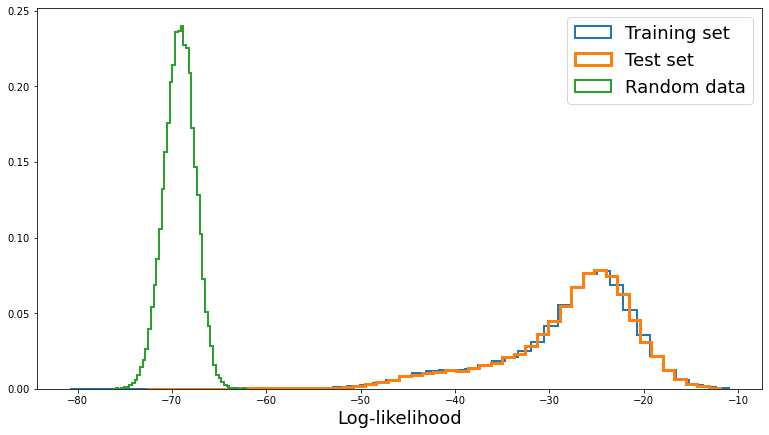

In [47]:
# check results on test set and on a set of random sequences
rand_data = np.random.randint(low=0, high=3, size=test_data.shape, dtype=np.int16)

fig = plt.figure(figsize=(13, 7), constrained_layout=False)
ax = fig.add_subplot()
ax.hist(RBM_DC8.likelihood(train_data_C), bins=50, density=True, histtype='step', lw=2, fill=False, label="Training set")
ax.hist(RBM_DC8.likelihood(test_data_C), bins=50, density=True, histtype='step', lw=3, fill=False, label="Test set")
ax.hist(RBM_DC8.likelihood(rand_data), bins=50, density=True, histtype='step', lw=2, fill=False, label="Random data")

ax.legend(fontsize=18, loc=1)
ax.set_xlabel("Log-likelihood", fontsize=18)
;

In [46]:
# save RBM
out_path = './RBM_retrained/'
if not os.path.isdir(out_path): # check if folder exists
    os.makedirs(out_path)
    
file_name = 'RBM_DC8.data'
RBM_utils.saveRBM(out_path + file_name, RBM_DC8)

# RBM-SC8 re-training

In [48]:
# fix training and validation set
perm = np.arange(all_seq_8_lr.shape[0])
np.random.shuffle(perm)

len_validation = all_seq_8_lr.shape[0] // 10
training_set_s2n = all_seq_8_lr[perm][:-len_validation]
training_set_counts = counts_8_lr[perm][:-len_validation]
validation_set_s2n = all_seq_8_lr[perm][-len_validation:]
validation_set_counts = counts_8_lr[perm][-len_validation:]

In [49]:
#resample training set with counts
dataset_size = training_set_s2n.shape[0] # same size of the training dataset used for RBM-SU
probs = training_set_counts
seqs = training_set_s2n
tot_probs = np.sum(probs)
probs2 = np.array(probs/tot_probs, dtype = np.float64)
tower = np.zeros(len(probs2), dtype = np.float64)
t = 0
for i, pr in enumerate(probs2):
    t = t + pr
    tower[i] = t
resampled_seq2num = []
for i in range(dataset_size):
    x = np.random.random()
    idx = tower.searchsorted(x)
    resampled_seq2num.append(seqs[idx])
resampled_seq2num = np.array(resampled_seq2num)
train_data_C = np.copy(resampled_seq2num)

In [50]:
# training
n_v = train_data_C.shape[1]
n_h = 80
nmc = 2
lib = 1e-2
visible = 'Potts'
n_cv = 4
hidden = 'dReLU'
train_len = train_data_C.shape[0]
RBM_SC = rbm.RBM(visible = visible, hidden = hidden, n_v = n_v, n_h = n_h, n_cv = n_cv)
batch_size = 1000
n_updates = int(2e4)
n_iter = (n_updates // (train_data_C.shape[0] // batch_size))
print('Using ', n_iter, ' epochs.')

RBM_SC.fit(train_data_C, batch_size = batch_size, n_iter = n_iter, l1b = lib, N_MC = nmc, verbose = 0, vverbose = 1)

Using  58  epochs.
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting epoch 11
Starting epoch 12
Starting epoch 13
Starting epoch 14
Starting epoch 15
Starting epoch 16
Starting epoch 17
Starting epoch 18
Starting epoch 19
Starting epoch 20
Starting epoch 21
Starting epoch 22
Starting epoch 23
Starting epoch 24
Starting epoch 25
Starting epoch 26
Starting epoch 27
Starting epoch 28
Starting epoch 29
Starting epoch 30
Starting epoch 31
Starting epoch 32
Starting epoch 33
Starting epoch 34
Starting epoch 35
Starting epoch 36
Starting epoch 37
Starting epoch 38
Starting epoch 39
Starting epoch 40
Starting epoch 41
Starting epoch 42
Starting epoch 43
Starting epoch 44
Starting epoch 45
Starting epoch 46
Starting epoch 47
Starting epoch 48
Starting epoch 49
Starting epoch 50
Starting epoch 51
Starting epoch 52
Starting epoch 53
Starting epoch 54
Starting epoch 55


{}

In [51]:
# resample test set with counts
dataset_size = validation_set_s2n.shape[0] # same size of the validation dataset used for RBM-SU
probs = validation_set_counts
seqs = validation_set_s2n
tot_probs = np.sum(probs)
probs2 = np.array(probs/tot_probs, dtype = np.float64)
tower = np.zeros(len(probs2), dtype = np.float64)
t = 0
for i, pr in enumerate(probs2):
    t = t + pr
    tower[i] = t
resampled_seq2num = []
for i in range(dataset_size):
    x = np.random.random()
    idx = tower.searchsorted(x)
    resampled_seq2num.append(seqs[idx])
resampled_seq2num = np.array(resampled_seq2num)
test_data_C = np.copy(resampled_seq2num)

Mismatch dimensions (1000, 80), [10, 80], reinitializating I
Mismatch dimensions (1000, 20, 4), [10, 20, 4], reinitializating I


''

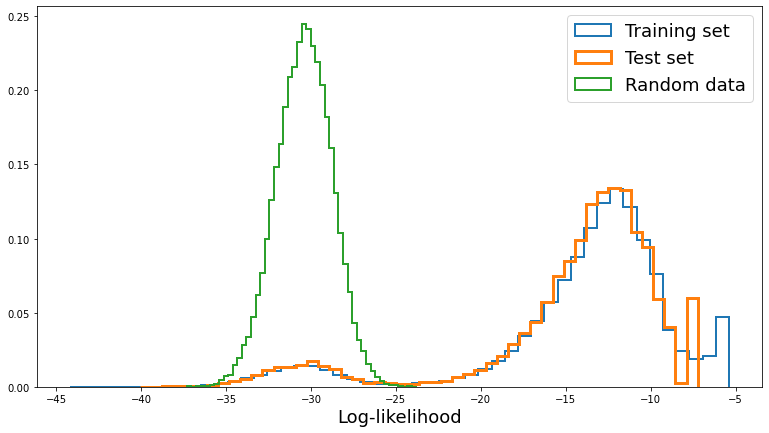

In [52]:
# check results on test set and on a set of random sequences
rand_data = np.random.randint(low=0, high=3, size=test_data.shape, dtype=np.int16)

fig = plt.figure(figsize=(13, 7), constrained_layout=False)
ax = fig.add_subplot()
ax.hist(RBM_SC.likelihood(train_data_C), bins=50, density=True, histtype='step', lw=2, fill=False, label="Training set")
ax.hist(RBM_SC.likelihood(test_data_C), bins=50, density=True, histtype='step', lw=3, fill=False, label="Test set")
ax.hist(RBM_SC.likelihood(rand_data), bins=50, density=True, histtype='step', lw=2, fill=False, label="Random data")

ax.legend(fontsize=18, loc=1)
ax.set_xlabel("Log-likelihood", fontsize=18)
;

In [53]:
# save RBM
out_path = './RBM_retrained/'
if not os.path.isdir(out_path): # check if folder exists
    os.makedirs(out_path)
    
file_name = 'RBM_SC.data'
RBM_utils.saveRBM(out_path + file_name, RBM_SC)

# RBM-SU8 re-training

In [27]:
# prepare training and test set
n_tot_8_lr = len(all_data_8_lr.sequence)
permutation = np.random.permutation(n_tot_8_lr)
rbm_s_dataset = all_seq_8_lr[permutation]
test_len = rbm_s_dataset.shape[0] // 10
train_data = rbm_s_dataset[test_len:]
test_data = rbm_s_dataset[:test_len]

In [28]:
# training
n_v = train_data.shape[1]
n_h = 70
nmc = 4
lib = 1e-2
visible = 'Potts'
n_cv = 4
hidden = 'dReLU'
train_len = train_data.shape[0]
test_len = test_data.shape[0]
RBM_SU = rbm.RBM(visible = visible, hidden = hidden, n_v = n_v, n_h = n_h, n_cv = n_cv)
batch_size = 500
n_updates = int(2e4)
n_iter = (n_updates // (train_data.shape[0] // batch_size))
print('Using ', n_iter, ' epochs.')

RBM_SU.fit(train_data, batch_size = batch_size, n_iter = n_iter, l1b = lib, N_MC = nmc, verbose = 0, vverbose = 1)

Using  29  epochs.
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting epoch 11
Starting epoch 12
Starting epoch 13
Starting epoch 14
Starting epoch 15
Starting epoch 16
Starting epoch 17
Starting epoch 18
Starting epoch 19
Starting epoch 20
Starting epoch 21
Starting epoch 22
Starting epoch 23
Starting epoch 24
Starting epoch 25
Starting epoch 26
Starting epoch 27
Starting epoch 28
Starting epoch 29


{}

Mismatch dimensions (500, 70), [10, 70], reinitializating I
Mismatch dimensions (500, 20, 4), [10, 20, 4], reinitializating I


''

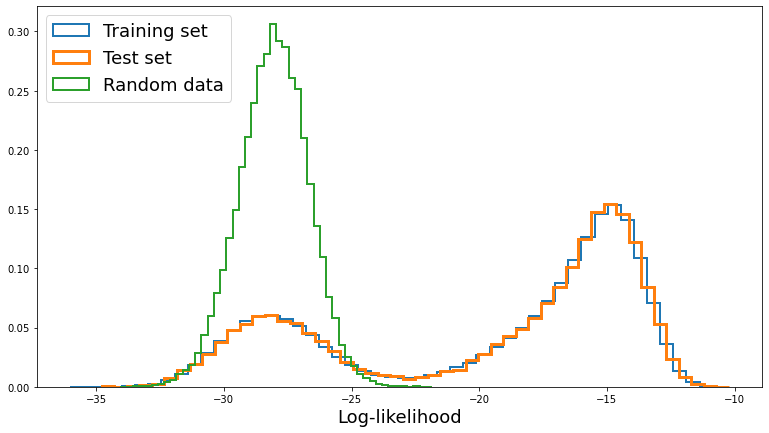

In [29]:
# check results on test set and on a set of random sequences
rand_data = np.random.randint(low=0, high=3, size=test_data.shape, dtype=np.int16)

fig = plt.figure(figsize=(13, 7), constrained_layout=False)
ax = fig.add_subplot()
ax.hist(RBM_SU.likelihood(train_data), bins=50, density=True, histtype='step', lw=2, fill=False, label="Training set")
ax.hist(RBM_SU.likelihood(test_data), bins=50, density=True, histtype='step', lw=3, fill=False, label="Test set")
ax.hist(RBM_SU.likelihood(rand_data), bins=50, density=True, histtype='step', lw=2, fill=False, label="Random data")

ax.legend(fontsize=18, loc=2)
ax.set_xlabel("Log-likelihood", fontsize=18)
;

In [30]:
# save RBM
out_path = './RBM_retrained/'
if not os.path.isdir(out_path): # check if folder exists
    os.makedirs(out_path)
    
file_name = 'RBM_SU.data'
RBM_utils.saveRBM(out_path + file_name, RBM_SU)